In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fd12345/CLEANED_FINAL_WO_SMALL.csv


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [4]:
df=pd.read_csv('/kaggle/input/fd12345/CLEANED_FINAL_WO_SMALL.csv')

In [5]:
X=df.drop(columns=['taxationType'])
y=df['taxationType']

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_transformed = label_encoder.fit_transform(y)

In [ ]:
del X
del y
del y_transformed

In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Определение модели XGBoost с использованием GPU
model = XGBClassifier(
    tree_method='hist',  # Используем гистограммный метод на CPU
    device='cuda',       # Указываем, что расчёты должны выполняться на GPU
    eval_metric='mlogloss',  # Метрика для мультиклассовой классификации
    use_label_encoder=False  # Отключение устаревшего кодировщика меток
)

# Определение сетки параметров для поиска
param_grid = {
    'max_depth': [10,13,16],  # Глубины деревьев
    'n_estimators': [100, 200,400],  # Количество деревьев
    'learning_rate': [0.01, 0.12, 0.07],  # Скорость обучения
    'gamma': [0, 0.1, 0.2],  # Минимальное уменьшение потерь для дальнейшего разделения
    'subsample': [0.8, 0.9, 1.0],  # Доля выборки, используемой для обучения каждого дерева
    'colsample_bytree': [0.8, 0.9, 1.0]  # Доля признаков, используемая для обучения каждого дерева
}

# Создание объекта GridSearchCV с указанием минимум 3 разделений для кросс-валидации
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,  # Указываем, что нужно использовать 3 разделения для кросс-валидации
    verbose=3,
    n_jobs=1  # Для GPU использовать n_jobs=1
)

# Обучение GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и лучшей достигнутой точности
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

# Использование лучшей модели для предсказаний на тестовом наборе
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Точность на тестовом наборе: {accuracy:.2f}%")


Fitting 2 folds for each of 729 candidates, totalling 1458 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:39:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/2] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.686 total time= 2.1min
[CV 2/2] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.686 total time= 2.1min
[CV 1/2] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9;, score=0.686 total time= 2.1min


KeyboardInterrupt: 

In [11]:
import cudf


X_train_cudf = cudf.DataFrame(X_train)
X_test_cudf = cudf.DataFrame(X_test)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

# Использование cuDF DataFrames в GridSearchCV будет сложно,
# так как GridSearchCV из scikit-learn не поддерживает напрямую cuDF.
# Но вы можете использовать XGBClassifier напрямую с cuDF:
model = XGBClassifier(tree_method='gpu_hist', device='cuda')
model.fit(X_train_cudf, y_train_cudf)

predictions = model.predict(X_test_cudf)
accuracy = accuracy_score(y_test_cudf.to_array(), predictions)
print(f"Точность на тестовом наборе: {accuracy:.2f}%")


/opt/conda/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 4) with CUDA driver version (12, 2) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 2) to continue using cuDF.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.B

---------------------------------------------------
--- JIT compile log for cupy_jitify_exercise ---
---------------------------------------------------
cub/util_cpp_dialect.cuh(143): warning #161-D: unrecognized #pragma
       CUB_COMPILER_DEPRECATION_SOFT(C++14, C++11);
       ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

std/barrier(16): catastrophic error: #error directive: "CUDA synchronization primitives are only supported for sm_70 and up."
  #  error "CUDA synchronization primitives are only supported for sm_70 and up."
     ^

1 catastrophic error detected in the compilation of "cupy_jitify_exercise".
Compilation terminated.
 
---------------------------------------------------


RuntimeError: Runtime compilation failed

In [12]:
!conda update cudf cuml dask-cudf pyarrow

Retrieving notices: ...working... done
done
Solving environment: / ^C
unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.

CondaError: KeyboardInterrupt



In [13]:

params = {
    'tree_method': 'hist',
    'device':'cuda',
    'num_class': 8,
    'max_depth': 15
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')])

predictions = model.predict(dtest)

accuracy = accuracy_score(y_test, predictions)
print("Точность: {:.2f}%".format(accuracy * 100))


[0]	test-mlogloss:1.51022
[1]	test-mlogloss:1.28232
[2]	test-mlogloss:1.13832
[3]	test-mlogloss:1.03857
[4]	test-mlogloss:0.96656
[5]	test-mlogloss:0.91350
[6]	test-mlogloss:0.87337
[7]	test-mlogloss:0.84235
[8]	test-mlogloss:0.81784
[9]	test-mlogloss:0.79789
[10]	test-mlogloss:0.78116
[11]	test-mlogloss:0.76795
[12]	test-mlogloss:0.75604
[13]	test-mlogloss:0.74601
[14]	test-mlogloss:0.73801
[15]	test-mlogloss:0.72995
[16]	test-mlogloss:0.72368
[17]	test-mlogloss:0.71649
[18]	test-mlogloss:0.71054
[19]	test-mlogloss:0.70556
[20]	test-mlogloss:0.70106
[21]	test-mlogloss:0.69738
[22]	test-mlogloss:0.69368
[23]	test-mlogloss:0.69035
[24]	test-mlogloss:0.68686
[25]	test-mlogloss:0.68333
[26]	test-mlogloss:0.67948
[27]	test-mlogloss:0.67678
[28]	test-mlogloss:0.67429
[29]	test-mlogloss:0.67127
[30]	test-mlogloss:0.66869
[31]	test-mlogloss:0.66664
[32]	test-mlogloss:0.66392
[33]	test-mlogloss:0.66191
[34]	test-mlogloss:0.65966
[35]	test-mlogloss:0.65785
[36]	test-mlogloss:0.65552
[37]	test-m

In [13]:
# Проверяем размеры
print("Размер обучающего набора:", X_train.shape)
print("Размер тестового набора:", X_test.shape)
print("Размер меток обучения:", y_train.shape)
print("Размер меток теста:", y_test.shape)


Размер обучающего набора: (29704953, 12)
Размер тестового набора: (7426239, 12)
Размер меток обучения: (29704953,)
Размер меток теста: (7426239,)


In [12]:

params = {
    'tree_method': 'hist',
    'device':'cuda',
    'num_class': 8,
    'max_depth':13
    
}
# Преобразование данных в формат DMatrix, оптимизированный для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Обучение модели
model = xgb.train(params, dtrain, num_boost_round=300, evals=[(dtest, 'test')])

# Предсказание и оценка модели
predictions = model.predict(dtest)

accuracy = accuracy_score(y_test, predictions)
print("Точность: {:.2f}%".format(accuracy * 100))


[0]	test-mlogloss:1.52382
[1]	test-mlogloss:1.30028
[2]	test-mlogloss:1.15889
[3]	test-mlogloss:1.06127
[4]	test-mlogloss:0.99123
[5]	test-mlogloss:0.93949
[6]	test-mlogloss:0.90019
[7]	test-mlogloss:0.87014
[8]	test-mlogloss:0.84644
[9]	test-mlogloss:0.82745
[10]	test-mlogloss:0.81158
[11]	test-mlogloss:0.79845
[12]	test-mlogloss:0.78753
[13]	test-mlogloss:0.77841
[14]	test-mlogloss:0.77073
[15]	test-mlogloss:0.76246
[16]	test-mlogloss:0.75455
[17]	test-mlogloss:0.74856
[18]	test-mlogloss:0.74391
[19]	test-mlogloss:0.73915
[20]	test-mlogloss:0.73396
[21]	test-mlogloss:0.72981
[22]	test-mlogloss:0.72668
[23]	test-mlogloss:0.72256
[24]	test-mlogloss:0.71915
[25]	test-mlogloss:0.71565
[26]	test-mlogloss:0.71265
[27]	test-mlogloss:0.70987
[28]	test-mlogloss:0.70607
[29]	test-mlogloss:0.70297
[30]	test-mlogloss:0.70000
[31]	test-mlogloss:0.69803
[32]	test-mlogloss:0.69591
[33]	test-mlogloss:0.69423
[34]	test-mlogloss:0.69277
[35]	test-mlogloss:0.69134
[36]	test-mlogloss:0.68874
[37]	test-m

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(params):
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_child_weight=params['min_child_weight'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        learning_rate=params['learning_rate'],
        tree_method='gpu_hist',  # Используем gpu_hist для обучения на GPU
        objective='multi:softprob',
        num_class=8,
        random_state=42
    )
    score = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
    return {'loss': -score, 'status': STATUS_OK}

space = {
    'max_depth': hp.quniform('max_depth', 10, 20, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 1, 4),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0)  # e^-3 to e^0
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

print("Лучшие найденные параметры:", best)


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

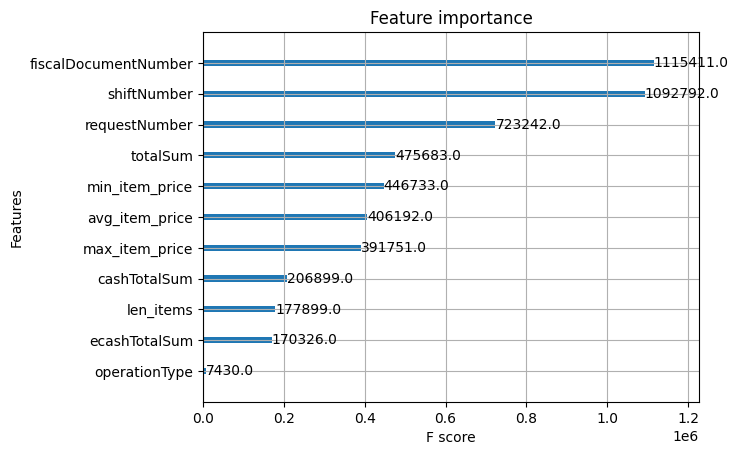

In [16]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Создание модели XGBoost
model = XGBClassifier(tree_method='gpu_hist')  # Включение GPU

# Определение пространства параметров
param_grid = {
    'max_depth': [12,13,15],
    'n_estimators': [100,200,400],
    'learning_rate': [0.01, 0.1, 0.2,0.05],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


In [19]:
model = XGBClassifier(tree_method='gpu_hist',device='cuda')
param_grid = {
    'max_depth': [12,13,15],
    'n_estimators': [100,200,400],
    'learning_rate': [0.01, 0.1, 0.2,0.05],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
bp={
    'score':0,
    'max_depth':0,
    'n_estimators':0,
    'learning_rate':0,
    'gamma':0,
    'subsample':0,
    'colsample_bytree':0
}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


t=3**5*4
i=0

for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            for gamma in param_grid['gamma']:
                for subsample in param_grid['subsample']:
                    for colsample_bytree in param_grid['colsample_bytree']:
                        
                        model=XGBClassifier(tree_method='gpu_hist',device='cuda',max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,gamma=gamma,subsample=subsample,colsample_bytree=colsample_bytree,objective='multi:softprob',num_class=8)
                        model = xgb.train(params, dtrain, num_boost_round=300, evals=[(dtest, 'test')])
                        predictions = model.predict(dtest)
                        accuracy = accuracy_score(y_test, predictions)
                        if accuracy>bp['score']:
                            bp['score']=accuracy
                            bp['max_depth']=max_depth
                            bp['n_estimators']=n_estimators
                            bp['learning_rate']=learning_rate
                            bp['gamma']=gamma
                            bp['colsample_bytree']=colsample_bytree
                        i+=1
                        print(i/t*100,'%',accuracy)
bp

XGBoostError: [21:34:20] /workspace/src/objective/objective.cc:27: Unknown objective function: `multiclass`
Objective candidate: rank:ndcg
Objective candidate: rank:pairwise
Objective candidate: rank:map
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: reg:quantileerror
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1ba24e) [0x7f22165e924e]
  [bt] (1) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x60c6ce) [0x7f2216a3b6ce]
  [bt] (2) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4b9c3f) [0x7f22168e8c3f]
  [bt] (3) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4cccd3) [0x7f22168fbcd3]
  [bt] (4) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4c5268) [0x7f22168f4268]
  [bt] (5) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f2216590ef0]
  [bt] (6) /opt/conda/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f2280d54a4a]
  [bt] (7) /opt/conda/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f2280d53fea]
  [bt] (8) /opt/conda/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7f2280d6c461]



In [ ]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Параметры
param_grid = {
    'max_depth': [12, 13, 15],
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.05],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
best_params = {
    'score': 0
}

total_combinations = len(param_grid['max_depth']) * len(param_grid['n_estimators']) * len(param_grid['learning_rate']) \
                     * len(param_grid['gamma']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree'])
current_combination = 0

# Перебор параметров
for max_depth in param_grid['max_depth'][::-1]:
    for n_estimators in param_grid['n_estimators'][::-1]:
        for learning_rate in param_grid['learning_rate'][::-1]:
            for gamma in param_grid['gamma'][::-1]:
                for subsample in param_grid['subsample'][::-1]:
                    for colsample_bytree in param_grid['colsample_bytree'][::-1]:
                        params = {
                            'max_depth': max_depth,
                            'eta': learning_rate,
                            'gamma': gamma,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree,
                            'objective': 'multi:softprob',
                            'num_class':8,
                            'eval_metric': 'mlogloss',
                            'tree_method': 'hist',
                            'device': 'cuda'
                        }
                        # Обучение модели
                        model = xgb.train(params, dtrain, num_boost_round=n_estimators, evals=[(dtest, 'test')], verbose_eval=False)

                        # Получение предсказаний
                        predictions = model.predict(dtest).argmax(axis=1)

                        # Вычисление точности
                        accuracy = accuracy_score(y_test, predictions)

                        # Обновление лучших параметров
                        if accuracy > best_params['score']:
                            best_params.update({
                                'score': accuracy,
                                'max_depth': max_depth,
                                'n_estimators': n_estimators,
                                'learning_rate': learning_rate,
                                'gamma': gamma,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree
                            })
                            print(best_params.values())

                        current_combination += 1
                        print(f"Progress: {current_combination/total_combinations*100:.2f}%, Current Accuracy: {accuracy:.4f}")

# Вывод лучших параметров
print("Best parameters:", best_params)


dict_values([0.7608117648785611, 15, 400, 0.05, 0.2, 1.0, 1.0])
Progress: 0.10%, Current Accuracy: 0.7608
dict_values([0.7613376030585604, 15, 400, 0.05, 0.2, 1.0, 0.9])
Progress: 0.21%, Current Accuracy: 0.7613
dict_values([0.7616048985226573, 15, 400, 0.05, 0.2, 1.0, 0.8])
Progress: 0.31%, Current Accuracy: 0.7616
Progress: 0.41%, Current Accuracy: 0.7614
Progress: 0.51%, Current Accuracy: 0.7610
Progress: 0.62%, Current Accuracy: 0.7612
Progress: 0.72%, Current Accuracy: 0.7612
Progress: 0.82%, Current Accuracy: 0.7608
Progress: 0.93%, Current Accuracy: 0.7611
Progress: 1.03%, Current Accuracy: 0.7610
Progress: 1.13%, Current Accuracy: 0.7608
Progress: 1.23%, Current Accuracy: 0.7614
Progress: 1.34%, Current Accuracy: 0.7615
Progress: 1.44%, Current Accuracy: 0.7613
Progress: 1.54%, Current Accuracy: 0.7614
dict_values([0.7620003880833892, 15, 400, 0.05, 0.1, 0.8, 1.0])
Progress: 1.65%, Current Accuracy: 0.7620
Progress: 1.75%, Current Accuracy: 0.7607
Progress: 1.85%, Current Accur

In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

KeyboardInterrupt: 

In [18]:
from cuml import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score


# Создание и обучение модели SVM на GPU
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)

# Предсказание
y_pred = svm_model.predict(X_test_scaled)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of SVM on GPU: {accuracy}')


/opt/conda/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 4) with CUDA driver version (12, 2) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 2) to continue using cuDF.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.B

ImportError: cannot import name 'is_datetime64tz_dtype' from 'pandas.core.tools.datetimes' (/opt/conda/lib/python3.10/site-packages/pandas/core/tools/datetimes.py)

In [17]:
X_train

,receiptCode,fiscalDocumentNumber,shiftNumber,requestNumber,operationType,totalSum,cashTotalSum,ecashTotalSum,len_items,avg_item_price,min_item_price,max_item_price
35185019,3.0,22568,301,80.0,1,24700.0,24700.0,0.0,1.0,24700.000000,24700.0,24700.0
7873377,3.0,37782,483,59.0,1,2800.0,0.0,2800.0,1.0,2800.000000,2800.0,2800.0
30095817,3.0,65424,128,1.0,1,35100.0,35100.0,0.0,8.0,4736.778198,1199.0,19990.0
34133039,3.0,5206,28,8.0,1,99968.0,0.0,99968.0,1.0,4499.009901,4499.0,4499.0
19373172,3.0,208233,734,30.0,1,2700.0,2700.0,0.0,1.0,900.000000,900.0,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26301898,3.0,70479,817,14.0,1,4800.0,4800.0,0.0,1.0,4800.000000,4800.0,4800.0
26735830,3.0,209063,251,4.0,1,128313.0,128313.0,0.0,1.0,128313.000000,128313.0,128313.0
35788921,3.0,59629,385,196.0,1,626350.0,0.0,626350.0,1.0,626350.000000,626350.0,626350.0
13315092,3.0,18875,344,6.0,1,115800.0,0.0,115800.0,12.0,7720.000000,2900.0,24900.0


In [ ]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)


In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score


# Создание объекта датасета для LightGBM
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 8,
    'metric': 'multi_logloss',
    'device': 'gpu',
    'verbose': 1,
    'min_data_in_leaf': 20,
    'max_depth': 10,
    'num_leaves':64
}

# Обучение модели
gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

# Предсказание
y_pred = gbm.predict(X_test_scaled)
# Выбор класса с наивысшей вероятностью
predictions = [np.argmax(line) for line in y_pred]

# Оценка модели
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 29704953, number of used features: 11
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (339.95 MB) transferred to GPU in 0.354753 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -2.291177
[LightGBM] [Info] Start training from score -0.584805
[LightGBM] [Info] Start training from score -3.530644
[LightGBM] [Info] Start training from score -2.717978
[LightGBM] [Info] Start training from score -1.485994
[LightGBM] [Info] Start training from score -5.836269
[LightGBM] [Info] Start training from score -4.066110
[LightGBM] [Info] Start training from score -12.718188


[LightGBM] [Fatal] Check failed: (best_split_info.right_count) > (0) at /usr/local/src/LightGBM/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 856 .



LightGBMError: Check failed: (best_split_info.right_count) > (0) at /usr/local/src/LightGBM/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 856 .


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score


# Создание датасета LightGBM
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 8,
    'metric': 'multi_logloss',
    'device': 'gpu',
    'num_leaves': 30,  # Обычное значение, можно уменьшить если есть переобучение
    'max_depth': 12,   # Не ограничиваем глубину деревьев
    'min_data_in_leaf': 20,  # Минимальное количество данных в листе
    'verbose':3# L2 регуляризация
}

# Обучение модели с выводом информации каждую итерацию
gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

# Получение предсказаний
y_pred = gbm.predict(X_test_scaled)
predictions = [np.argmax(line) for line in y_pred]

# Оценка точности
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')


In [ ]:
from cuml.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import cudf

# Загрузка данных
data = load_iris()
X = cudf.DataFrame(data.data)
y = cudf.Series(data.target)
# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели SVM на GPU
svm_model = SVC(kernel='linear')
svm_model.fit(cudf.DataFrame(X_train_scaled), cudf.Series(y_train))

# Получение предсказаний
y_pred = svm_model.predict(cudf.DataFrame(X_test_scaled))

# Оценка точности
accuracy = accuracy_score(y_test.to_array(), y_pred.to_array())
print(f'Accuracy of SVM on GPU: {accuracy}')
